In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import datetime
from statsmodels.tsa.stattools import adfuller

# 1. Data Collection

In [42]:
tcs_stock_data = yf.download('TCS.NS', start='2010-01-01', end='2024-09-19')
tcs_stock_data.fillna(0, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [43]:
df = pd.DataFrame(tcs_stock_data)
df
# df.to_csv('TCS_stock')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,377.399994,379.450012,374.524994,375.825012,293.465515,1963682
2010-01-05,377.500000,379.774994,373.274994,375.924988,293.543671,2014488
2010-01-06,375.924988,376.100006,366.500000,367.424988,286.906342,3349176
2010-01-07,367.750000,369.700012,355.500000,357.200012,278.922089,6474892
2010-01-08,358.000000,359.250000,348.250000,349.899994,273.221924,6048178
...,...,...,...,...,...,...
2024-09-12,4510.250000,4532.600098,4431.299805,4517.700195,4517.700195,2742216
2024-09-13,4530.000000,4547.000000,4505.000000,4522.600098,4522.600098,1458786
2024-09-16,4527.000000,4546.049805,4494.450195,4513.250000,4513.250000,1155120


In [44]:
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2024-09-05', '2024-09-06', '2024-09-09', '2024-09-10',
               '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-16',
               '2024-09-17', '2024-09-18'],
              dtype='datetime64[ns]', name='Date', length=3630, freq=None)

# 2. Data Preprocessing

<AxesSubplot: xlabel='Date'>

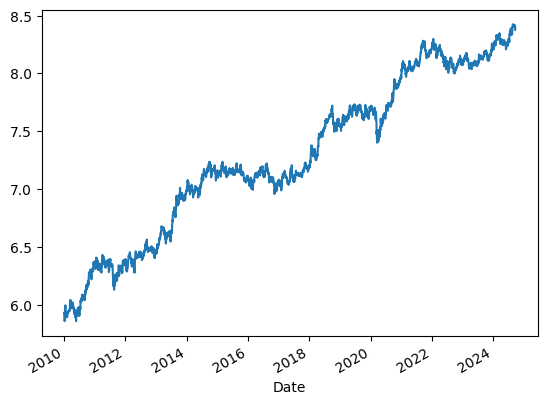

In [45]:
# This applies the natural logarithm (logarithm with base e) to the Close column of the DataFrame df.
# The reason for taking the logarithm of the closing prices is to stabilize the variance,
#  which can help in time series modeling (especially when working with non-stationary data). 
# Log transformations can reduce the effect of large fluctuations and make the data more stationary.


y = np.log(df["Close"])
y.plot()

In [46]:
y.asfreq("D")[:15] 

Date
2010-01-04    5.929124
2010-01-05    5.929390
2010-01-06    5.906519
2010-01-07    5.878296
2010-01-08    5.857647
2010-01-09         NaN
2010-01-10         NaN
2010-01-11    5.878016
2010-01-12    5.926993
2010-01-13    5.977049
2010-01-14    5.965954
2010-01-15    5.980656
2010-01-16         NaN
2010-01-17         NaN
2010-01-18    5.994211
Freq: D, Name: Close, dtype: float64

Let's impute the missing data by forward fill using asfreq method.

In [47]:
y.asfreq("D", method="ffill")[:15]   # used to forward fill missing values.

Date
2010-01-04    5.929124
2010-01-05    5.929390
2010-01-06    5.906519
2010-01-07    5.878296
2010-01-08    5.857647
2010-01-09    5.857647
2010-01-10    5.857647
2010-01-11    5.878016
2010-01-12    5.926993
2010-01-13    5.977049
2010-01-14    5.965954
2010-01-15    5.980656
2010-01-16    5.980656
2010-01-17    5.980656
2010-01-18    5.994211
Freq: D, Name: Close, dtype: float64

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05,
we can say that there is not sufficient proof that the time series is stationary. 
Loosely speaking, it is non-stationary. We need further transformation to make data stationary.
Populary method for making data stationary will be to take "difference". 
Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. 
So we conclude, diff 1 will made the data stationary. 

In [48]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(prices):
    result=adfuller(prices)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
adfuller_test(df['Close'])

ADF Test Statistic : 0.6990424581866237
p-value : 0.9898187408362258
#Lags Used : 30
Number of Observations Used : 3599
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [49]:
result = adfuller(y.diff(periods=1).dropna())

In [50]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.985378
p-value: 0.000000


<AxesSubplot: xlabel='Date'>

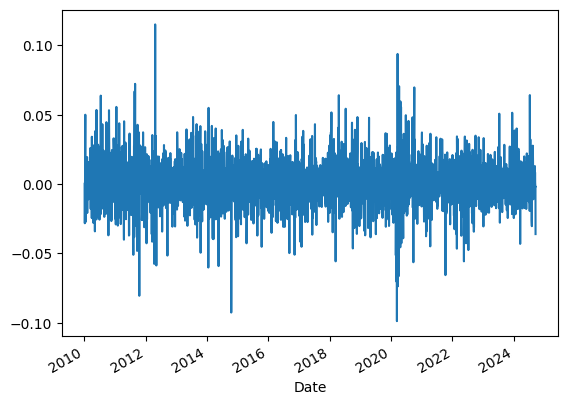

In [51]:
y.diff(periods=1).plot()

In [52]:
y

Date
2010-01-04    5.929124
2010-01-05    5.929390
2010-01-06    5.906519
2010-01-07    5.878296
2010-01-08    5.857647
                ...   
2024-09-12    8.415758
2024-09-13    8.416842
2024-09-16    8.414773
2024-09-17    8.413087
2024-09-18    8.377046
Name: Close, Length: 3630, dtype: float64

In [53]:
y = y.dropna()

# 3. Finding the p,d,q

Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF. p,d,q

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
p AR model lags d differencing q MA lags

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


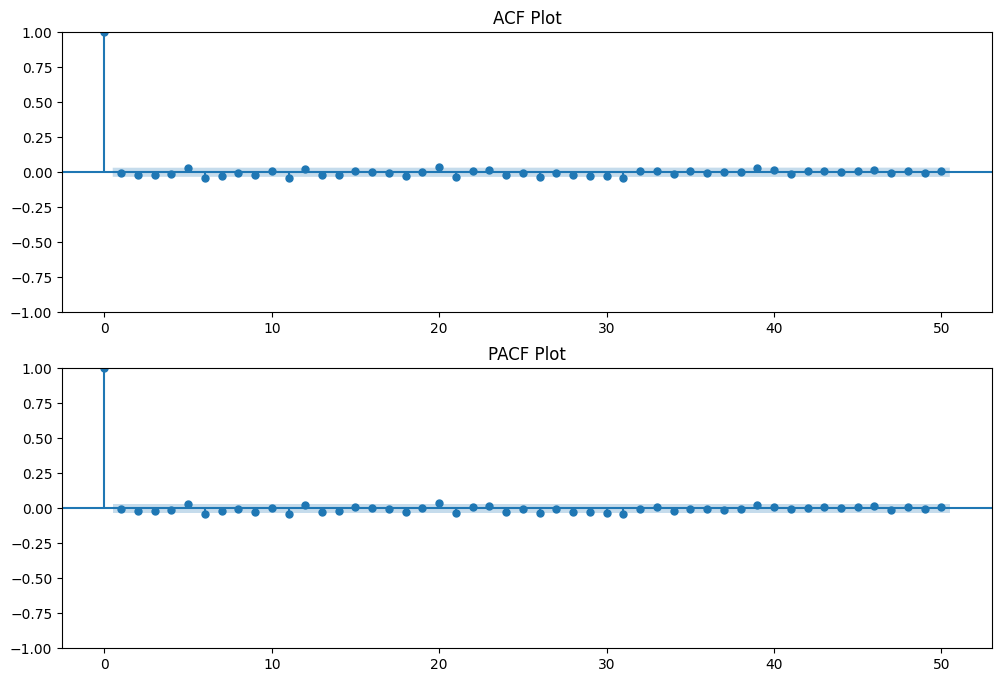

In [54]:
# Plot ACF and PACF for differenced data

plt.figure(figsize=(12, 8))

# ACF plot
plt.subplot(211)
plot_acf(y.diff(periods=1).dropna(), ax=plt.gca(), lags=50)
plt.title('ACF Plot')


# PACF plot
plt.subplot(212)
plot_pacf(y.diff(periods=1).dropna(), ax=plt.gca(), lags=50)
plt.title('PACF Plot')
plt.show()

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


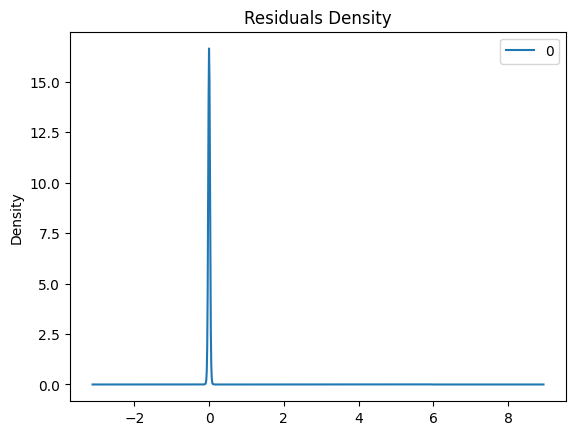

                 0
count  3630.000000
mean      0.002322
std       0.099635
min      -0.100833
25%      -0.007632
50%       0.000440
75%       0.009004
max       5.929124


In [55]:
from statsmodels.tsa.arima.model import ARIMA


# fit model
# model = ARIMA(y, order=(5, 1, 0))  # p, d, q
model = ARIMA(y, order=(5, 1, 0))
model_fit = model.fit()

#print(model_fit.summary())

import pandas as pd
import matplotlib.pyplot as plt

# Residual density refers to the distribution of residuals from a statistical model. 
# Residuals are the differences between the observed values and the values predicted by the model.

# Purpose: By examining the residual density, you can assess whether residuals are normally distributed 
# and identify any patterns or anomalies that suggest problems with the model.

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# residuals.plot(kind='kde')
# print(residuals.describe())

# Plot residuals density
residuals.plot(kind='kde')
plt.title('Residuals Density')
plt.show()

# Print residuals description
print(residuals.describe())


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


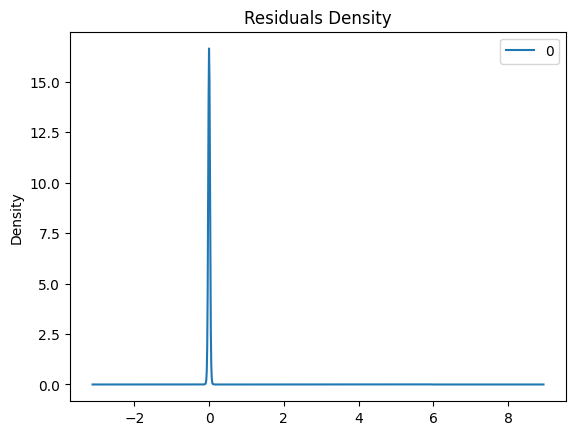

                 0
count  3630.000000
mean      0.002322
std       0.099635
min      -0.100833
25%      -0.007632
50%       0.000440
75%       0.009004
max       5.929124


In [56]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(1, 1, 1))
model_fit = model.fit()

#print(model_fit.summary())

import pandas as pd
import matplotlib.pyplot as plt

# Plot residuals density
residuals.plot(kind='kde')
plt.title('Residuals Density')
plt.show()

# Print residuals description
print(residuals.describe())


In [57]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3630
Model:                 ARIMA(1, 1, 1)   Log Likelihood                9932.703
Date:                Thu, 19 Sep 2024   AIC                         -19859.407
Time:                        12:19:27   BIC                         -19840.817
Sample:                             0   HQIC                        -19852.784
                               - 3630                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8866      0.257      3.450      0.001       0.383       1.390
ma.L1         -0.8923      0.251     -3.555      0.000      -1.384      -0.400
sigma2         0.0002   3.43e-06     71.573      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2097.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
model.endog

array([[5.92912364],
       [5.92938962],
       [5.90651918],
       ...,
       [8.41477279],
       [8.41308742],
       [8.37704565]])

# 4 . Data Splitting and Model Fitting

Spliting the data
we split the normalized data into training and testing sets :

70% for training,
30% for testing.

predicted=7.527245, actual=7.552578
predicted=7.554492, actual=7.608101
predicted=7.606225, actual=7.565508
predicted=7.564868, actual=7.566699


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.565942, actual=7.551502
predicted=7.551822, actual=7.545205
predicted=7.548318, actual=7.546129
predicted=7.544997, actual=7.568018
predicted=7.568404, actual=7.575328
predicted=7.574745, actual=7.575405
predicted=7.574707, actual=7.550845
predicted=7.550331, actual=7.545865
predicted=7.546634, actual=7.573326
predicted=7.573911, actual=7.574892
predicted=7.575335, actual=7.577429
predicted=7.576179, actual=7.596493
predicted=7.595445, actual=7.611026
predicted=7.611548, actual=7.571988
predicted=7.571725, actual=7.603549
predicted=7.603013, actual=7.603050
predicted=7.603646, actual=7.586981
predicted=7.588027, actual=7.623275
predicted=7.621038, actual=7.624204
predicted=7.625020, actual=7.623715
predicted=7.623577, actual=7.645661
predicted=7.643940, actual=7.624741
predicted=7.625812, actual=7.636149
predicted=7.635990, actual=7.636294
predicted=7.635816, actual=7.653851
predicted=7.654787, actual=7.634168
predicted=7.633229, actual=7.620460
predicted=7.620906, actual=7

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.622598, actual=7.614781
predicted=7.615122, actual=7.618399
predicted=7.618563, actual=7.621783
predicted=7.621596, actual=7.608920
predicted=7.609292, actual=7.658629
predicted=7.657784, actual=7.650478
predicted=7.650258, actual=7.641156
predicted=7.641092, actual=7.645900
predicted=7.644237, actual=7.676543
predicted=7.678029, actual=7.696053
predicted=7.695395, actual=7.724535
predicted=7.723161, actual=7.727491
predicted=7.726213, actual=7.704767
predicted=7.704960, actual=7.698188
predicted=7.698279, actual=7.706321
predicted=7.707495, actual=7.705262
predicted=7.706005, actual=7.683381
predicted=7.682942, actual=7.711504
predicted=7.711049, actual=7.711885
predicted=7.712157, actual=7.696553
predicted=7.696869, actual=7.699797
predicted=7.698511, actual=7.707535
predicted=7.708471, actual=7.692090
predicted=7.692542, actual=7.683035
predicted=7.682681, actual=7.676659
predicted=7.676950, actual=7.699299
predicted=7.699907, actual=7.744895
predicted=7.744039, actual=7

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.864367, actual=7.876107
predicted=7.875950, actual=7.883503
predicted=7.883395, actual=7.895697
predicted=7.896305, actual=7.903762
predicted=7.902386, actual=7.910811
predicted=7.910697, actual=7.882164
predicted=7.882213, actual=7.896478
predicted=7.896835, actual=7.890227
predicted=7.890565, actual=7.884897


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.885786, actual=7.889965
predicted=7.888743, actual=7.888353
predicted=7.889002, actual=7.873465
predicted=7.873503, actual=7.877359
predicted=7.877231, actual=7.886175
predicted=7.886414, actual=7.909948


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.909843, actual=7.909141
predicted=7.908137, actual=7.901488
predicted=7.901203, actual=7.908608
predicted=7.908372, actual=7.893441
predicted=7.894417, actual=7.910884


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.910963, actual=7.919193
predicted=7.918624, actual=7.904501
predicted=7.904958, actual=7.911159
predicted=7.910233, actual=7.914873
predicted=7.915304, actual=7.936410
predicted=7.936693, actual=7.941224
predicted=7.940169, actual=7.931752
predicted=7.931667, actual=7.931500
predicted=7.931171, actual=7.936553
predicted=7.937249, actual=7.923547
predicted=7.924022, actual=7.942433
predicted=7.942016, actual=7.950925
predicted=7.950595, actual=7.958926
predicted=7.958994, actual=7.944545
predicted=7.943580, actual=7.962938
predicted=7.963261, actual=7.975479
predicted=7.975362, actual=7.975685
predicted=7.975908, actual=7.982553
predicted=7.981389, actual=7.982928
predicted=7.983161, actual=7.975668
predicted=7.976085, actual=7.959538
predicted=7.959650, actual=7.982160
predicted=7.982435, actual=8.019432
predicted=8.019103, actual=8.036897
predicted=8.036059, actual=8.023389
predicted=8.021680, actual=8.017242
predicted=8.017156, actual=8.045877
predicted=8.046788, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.087108, actual=8.081274
predicted=8.081585, actual=8.077680
predicted=8.077531, actual=8.089697
predicted=8.088920, actual=8.104341
predicted=8.105186, actual=8.093722
predicted=8.093330, actual=8.102617
predicted=8.102154, actual=8.099038
predicted=8.099181, actual=8.089805
predicted=8.090578, actual=8.069827
predicted=8.069658, actual=8.042812
predicted=8.043851, actual=8.051771
predicted=8.052419, actual=8.071984
predicted=8.072092, actual=8.070922
predicted=8.070355, actual=8.067290
predicted=8.065954, actual=8.057678
predicted=8.057730, actual=8.075303
predicted=8.076090, actual=8.063661
predicted=8.063639, actual=8.075054
predicted=8.074977, actual=8.072779
predicted=8.072068, actual=8.068027
predicted=8.068824, actual=8.051930
predicted=8.051551, actual=8.041992
predicted=8.042850, actual=8.030442
predicted=8.030930, actual=8.025304
predicted=8.025821, actual=8.030035
predicted=8.029866, actual=7.992421
predicted=7.992632, actual=7.999746
predicted=7.999892, actual=7

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.024009, actual=8.029351
predicted=8.029947, actual=8.035538
predicted=8.035462, actual=8.033334
predicted=8.032933, actual=8.026170
predicted=8.025678, actual=8.032847
predicted=8.033068, actual=8.033172
predicted=8.033401, actual=8.043663
predicted=8.043485, actual=8.057853
predicted=8.057148, actual=8.064636
predicted=8.064371, actual=8.053124
predicted=8.052731, actual=8.058058
predicted=8.058277, actual=8.056110
predicted=8.056602, actual=8.048613
predicted=8.049068, actual=8.052376
predicted=8.052032, actual=8.053172
predicted=8.053408, actual=8.065642
predicted=8.065499, actual=8.070953
predicted=8.070325, actual=8.070984
predicted=8.070811, actual=8.076142
predicted=8.075841, actual=8.093707
predicted=8.093796, actual=8.094485
predicted=8.094248, actual=8.090326
predicted=8.090006, actual=8.093875
predicted=8.093817, actual=8.107042
predicted=8.107518, actual=8.100859
predicted=8.100700, actual=8.093493
predicted=8.093287, actual=8.102041
predicted=8.102120, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.114424, actual=8.109360
predicted=8.108928, actual=8.108021
predicted=8.108170, actual=8.090188
predicted=8.090538, actual=8.094058
predicted=8.094420, actual=8.089022


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.089110, actual=8.073450
predicted=8.073884, actual=8.068748
predicted=8.068477, actual=8.067008
predicted=8.067557, actual=8.075443
predicted=8.075524, actual=8.071828
predicted=8.071240, actual=8.069280
predicted=8.069114, actual=8.066082
predicted=8.066023, actual=8.072717
predicted=8.073107, actual=8.076002
predicted=8.075795, actual=8.074914
predicted=8.074722, actual=8.070140
predicted=8.069945, actual=8.065564
predicted=8.065907, actual=8.070218
predicted=8.070466, actual=8.069593
predicted=8.069609, actual=8.060682
predicted=8.060616, actual=8.076950
predicted=8.076733, actual=8.097091
predicted=8.096872, actual=8.093752
predicted=8.093261, actual=8.096802
predicted=8.095982, actual=8.104643
predicted=8.104823, actual=8.108533
predicted=8.109063, actual=8.111898
predicted=8.111511, actual=8.114983
predicted=8.114821, actual=8.117238
predicted=8.117328, actual=8.150006
predicted=8.149691, actual=8.152760
predicted=8.152128, actual=8.175562
predicted=8.174921, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.215775, actual=8.239184
predicted=8.239301, actual=8.220120
predicted=8.219929, actual=8.252381
predicted=8.252581, actual=8.253761
predicted=8.252971, actual=8.256348
predicted=8.256952, actual=8.246932
predicted=8.245850, actual=8.235930


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.237342, actual=8.240491
predicted=8.240772, actual=8.254620
predicted=8.254768, actual=8.265110
predicted=8.264496, actual=8.282622
predicted=8.281595, actual=8.269578
predicted=8.269246, actual=8.250059
predicted=8.250598, actual=8.248922
predicted=8.249594, actual=8.259186
predicted=8.260224, actual=8.258979
predicted=8.258616, actual=8.260816
predicted=8.259942, actual=8.261346
predicted=8.261124, actual=8.252433
predicted=8.252872, actual=8.237254
predicted=8.237523, actual=8.240622
predicted=8.241044, actual=8.236301
predicted=8.236662, actual=8.224217
predicted=8.224255, actual=8.235705
predicted=8.235254, actual=8.251481
predicted=8.251479, actual=8.245621
predicted=8.245251, actual=8.266910
predicted=8.265956, actual=8.277831
predicted=8.277617, actual=8.212189
predicted=8.213067, actual=8.203263
predicted=8.203934, actual=8.203906
predicted=8.205549, actual=8.191865
predicted=8.193514, actual=8.201701
predicted=8.199711, actual=8.198130
predicted=8.197815, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.137765, actual=8.130869
predicted=8.131272, actual=8.153753
predicted=8.153771, actual=8.155994


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.156008, actual=8.158302
predicted=8.157362, actual=8.162987
predicted=8.162246, actual=8.161304
predicted=8.161968, actual=8.162145
predicted=8.162152, actual=8.156022
predicted=8.156093, actual=8.157141
predicted=8.157430, actual=8.167934
predicted=8.167808, actual=8.175632
predicted=8.175462, actual=8.176504
predicted=8.175975, actual=8.166756
predicted=8.166598, actual=8.153551
predicted=8.154111, actual=8.148561
predicted=8.149249, actual=8.150251
predicted=8.150697, actual=8.144186


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.144152, actual=8.144940
predicted=8.144648, actual=8.145216
predicted=8.145073, actual=8.161090
predicted=8.161081, actual=8.168812
predicted=8.168202, actual=8.182503
predicted=8.182044, actual=8.200535
predicted=8.199763, actual=8.199863


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.199782, actual=8.170865
predicted=8.170936, actual=8.184374
predicted=8.184996, actual=8.196134
predicted=8.196762, actual=8.189175
predicted=8.189287, actual=8.198859
predicted=8.197534, actual=8.191366
predicted=8.191602, actual=8.195278


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.195796, actual=8.180419
predicted=8.180178, actual=8.183565
predicted=8.184238, actual=8.184332
predicted=8.184128, actual=8.176645
predicted=8.177048, actual=8.190992
predicted=8.190424, actual=8.197195
predicted=8.197041, actual=8.205956
predicted=8.205724, actual=8.208192
predicted=8.207411, actual=8.215034
predicted=8.215205, actual=8.217857
predicted=8.217735, actual=8.214655
predicted=8.214810, actual=8.225168
predicted=8.225057, actual=8.226400
predicted=8.226412, actual=8.247417
predicted=8.247212, actual=8.264814
predicted=8.263947, actual=8.258669
predicted=8.258478, actual=8.244715
predicted=8.244433, actual=8.256737
predicted=8.257420, actual=8.263552
predicted=8.264131, actual=8.272800
predicted=8.272444, actual=8.258397
predicted=8.257574, actual=8.268193
predicted=8.268580, actual=8.286055
predicted=8.285965, actual=8.298826
predicted=8.298785, actual=8.291697
predicted=8.290616, actual=8.272481
predicted=8.272698, actual=8.249719
predicted=8.250819, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.247436, actual=8.246198
predicted=8.246044, actual=8.238590
predicted=8.237496, actual=8.241150
predicted=8.241301, actual=8.221318
predicted=8.222324, actual=8.184904
predicted=8.185621, actual=8.178583
predicted=8.179318, actual=8.132016
predicted=8.133296, actual=8.166429
predicted=8.167016, actual=8.175885


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.174703, actual=8.173618
predicted=8.173610, actual=8.173124
predicted=8.170850, actual=8.167451
predicted=8.168537, actual=8.156195
predicted=8.156756, actual=8.188675
predicted=8.188615, actual=8.197704
predicted=8.197261, actual=8.194492
predicted=8.193912, actual=8.188453
predicted=8.187464, actual=8.200563
predicted=8.201554, actual=8.186993


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.187320, actual=8.204098
predicted=8.204030, actual=8.208696
predicted=8.208106, actual=8.196078
predicted=8.196517, actual=8.216345
predicted=8.215564, actual=8.219434
predicted=8.219678, actual=8.229471
predicted=8.229437, actual=8.218100


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.217180, actual=8.218167
predicted=8.218868, actual=8.217533


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.217616, actual=8.224579
predicted=8.225068, actual=8.226828
predicted=8.226299, actual=8.231842
predicted=8.231670, actual=8.234923
predicted=8.234621, actual=8.246644
predicted=8.246607, actual=8.230937
predicted=8.230807, actual=8.211795
predicted=8.212213, actual=8.212202
predicted=8.212671, actual=8.215115
predicted=8.216025, actual=8.213680
predicted=8.213453, actual=8.205751
predicted=8.205160, actual=8.168501
predicted=8.168953, actual=8.152457
predicted=8.153519, actual=8.176617
predicted=8.177360, actual=8.196616
predicted=8.196620, actual=8.192169
predicted=8.190436, actual=8.174196
predicted=8.173124, actual=8.173660
predicted=8.174605, actual=8.177853


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.178896, actual=8.184318
predicted=8.184348, actual=8.173773
predicted=8.173025, actual=8.172560
predicted=8.172597, actual=8.154716
predicted=8.155083, actual=8.164339
predicted=8.165065, actual=8.141073
predicted=8.141003, actual=8.144708
predicted=8.145253, actual=8.142863
predicted=8.142385, actual=8.135054
predicted=8.135838, actual=8.134072
predicted=8.133378, actual=8.135903
predicted=8.136192, actual=8.124684
predicted=8.124824, actual=8.146593
predicted=8.146340, actual=8.145782
predicted=8.145460, actual=8.090080
predicted=8.090511, actual=8.099554
predicted=8.099900, actual=8.108247
predicted=8.109566, actual=8.098035
predicted=8.098738, actual=8.060745
predicted=8.059090, actual=8.079293
predicted=8.080305, actual=8.089881
predicted=8.090321, actual=8.124225
predicted=8.123580, actual=8.120990
predicted=8.118532, actual=8.118267
predicted=8.118294, actual=8.138273
predicted=8.138071, actual=8.143270
predicted=8.144047, actual=8.140592
predicted=8.140128, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.034733, actual=8.043149
predicted=8.043701, actual=8.074633
predicted=8.074651, actual=8.078052
predicted=8.076646, actual=8.104341
predicted=8.102929, actual=8.099585
predicted=8.098839, actual=8.106122
predicted=8.106811, actual=8.107163
predicted=8.106886, actual=8.098795
predicted=8.099682, actual=8.091658
predicted=8.091651, actual=8.106243
predicted=8.106630, actual=8.081800
predicted=8.081902, actual=8.075987
predicted=8.076185, actual=8.089713
predicted=8.089685, actual=8.097989
predicted=8.098457, actual=8.091153
predicted=8.090070, actual=8.043599
predicted=8.043640, actual=8.034210
predicted=8.035902, actual=8.019202
predicted=8.020615, actual=8.005951
predicted=8.006823, actual=8.004566
predicted=8.003582, actual=8.027313
predicted=8.027263, actual=8.030816
predicted=8.029951, actual=8.059845
predicted=8.058832, actual=8.063787
predicted=8.062742, actual=8.061802
predicted=8.061975, actual=8.060461
predicted=8.060216, actual=8.044273
predicted=8.045307, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.067802, actual=8.089636
predicted=8.089174, actual=8.102253
predicted=8.101486, actual=8.101314
predicted=8.099870, actual=8.099190
predicted=8.099504, actual=8.113576
predicted=8.114140, actual=8.118192
predicted=8.118306, actual=8.121198
predicted=8.120853, actual=8.123988
predicted=8.123589, actual=8.117983
predicted=8.118330, actual=8.138127
predicted=8.138224, actual=8.131987
predicted=8.131730, actual=8.129381
predicted=8.129395, actual=8.131854
predicted=8.131543, actual=8.126001
predicted=8.126772, actual=8.127331
predicted=8.127242, actual=8.118073
predicted=8.118067, actual=8.097000
predicted=8.097461, actual=8.088055
predicted=8.088496, actual=8.076577
predicted=8.077305, actual=8.077820
predicted=8.078144, actual=8.049603
predicted=8.049272, actual=8.074384
predicted=8.074658, actual=8.049331
predicted=8.049011, actual=8.048916
predicted=8.049433, actual=8.049874
predicted=8.049009, actual=8.047845
predicted=8.048975, actual=8.055031
predicted=8.054160, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.044527, actual=8.029286
predicted=8.030392, actual=8.039399
predicted=8.039650, actual=8.040221
predicted=8.039613, actual=8.038883
predicted=8.039535, actual=8.042941
predicted=8.042239, actual=8.053474
predicted=8.053677, actual=8.046181
predicted=8.046013, actual=8.057473
predicted=8.057271, actual=8.051150
predicted=8.051090, actual=8.058865
predicted=8.059215, actual=8.058992
predicted=8.058538, actual=8.057504
predicted=8.057868, actual=8.059355
predicted=8.059048, actual=8.068763
predicted=8.068943, actual=8.089390
predicted=8.089053, actual=8.083853
predicted=8.083276, actual=8.073013
predicted=8.072826, actual=8.076329
predicted=8.076659, actual=8.081382
predicted=8.082234, actual=8.075909
predicted=8.075748, actual=8.072670


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.072307, actual=8.106499
predicted=8.106438, actual=8.112378
predicted=8.111950, actual=8.111508
predicted=8.110740, actual=8.118311
predicted=8.117651, actual=8.116417
predicted=8.117388, actual=8.114758
predicted=8.114919, actual=8.096665
predicted=8.096743, actual=8.106198
predicted=8.106766, actual=8.104190
predicted=8.104243, actual=8.125675
predicted=8.125577, actual=8.128482
predicted=8.127336, actual=8.130133
predicted=8.130081, actual=8.130751
predicted=8.130329, actual=8.128821
predicted=8.129487, actual=8.153537
predicted=8.153453, actual=8.142980
predicted=8.142659, actual=8.139119
predicted=8.139023, actual=8.127213
predicted=8.127167, actual=8.125809
predicted=8.127095, actual=8.116880
predicted=8.116852, actual=8.099478
predicted=8.099821, actual=8.097563
predicted=8.097660, actual=8.111358
predicted=8.111625, actual=8.121287
predicted=8.120889, actual=8.103222
predicted=8.102374, actual=8.083406
predicted=8.083518, actual=8.071547
predicted=8.072668, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.091598, actual=8.089390
predicted=8.088496, actual=8.079726
predicted=8.079147, actual=8.087302
predicted=8.087854, actual=8.089329
predicted=8.089619, actual=8.088593
predicted=8.088453, actual=8.092163
predicted=8.091689, actual=8.088470
predicted=8.088677, actual=8.089927
predicted=8.090013, actual=8.105111
predicted=8.104966, actual=8.106107
predicted=8.105937, actual=8.105036
predicted=8.104625, actual=8.074509
predicted=8.074594, actual=8.107705


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.108600, actual=8.097548
predicted=8.097536, actual=8.110337
predicted=8.110161, actual=8.112033
predicted=8.110483, actual=8.124017
predicted=8.124917, actual=8.111943
predicted=8.111301, actual=8.125157
predicted=8.125471, actual=8.128585
predicted=8.128441, actual=8.123588
predicted=8.123872, actual=8.120618
predicted=8.120129, actual=8.135903
predicted=8.136318, actual=8.142151
predicted=8.142017, actual=8.140243
predicted=8.139730, actual=8.134775
predicted=8.134490, actual=8.141379
predicted=8.141911, actual=8.119309
predicted=8.119711, actual=8.133984
predicted=8.134145, actual=8.149139


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.148843, actual=8.155448
predicted=8.155287, actual=8.149009
predicted=8.147783, actual=8.152644
predicted=8.152954, actual=8.166245
predicted=8.166603, actual=8.172122
predicted=8.172012, actual=8.171190
predicted=8.170587, actual=8.155477
predicted=8.155518, actual=8.160547
predicted=8.161227, actual=8.166401


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.166736, actual=8.176968
predicted=8.176789, actual=8.160847
predicted=8.160098, actual=8.156883
predicted=8.157164, actual=8.146419
predicted=8.146986, actual=8.131987
predicted=8.132916, actual=8.135581
predicted=8.135520, actual=8.131663
predicted=8.131861, actual=8.111283
predicted=8.111268, actual=8.105564
predicted=8.105562, actual=8.127316
predicted=8.127758, actual=8.108157
predicted=8.108064, actual=8.114370
predicted=8.113686, actual=8.123217
predicted=8.122932, actual=8.128703
predicted=8.129272, actual=8.112783
predicted=8.111984, actual=8.111028
predicted=8.111396, actual=8.096193
predicted=8.096890, actual=8.075567
predicted=8.076417, actual=8.070562
predicted=8.070774, actual=8.066208
predicted=8.066782, actual=8.064416
predicted=8.064315, actual=8.053028
predicted=8.052610, actual=8.041123
predicted=8.041358, actual=8.049044
predicted=8.049274, actual=8.047078
predicted=8.047183, actual=8.045749
predicted=8.045398, actual=8.046325
predicted=8.045914, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.109269, actual=8.110502
predicted=8.110010, actual=8.093141
predicted=8.093586, actual=8.093279
predicted=8.093668, actual=8.089452


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.089807, actual=8.113891
predicted=8.113948, actual=8.164695
predicted=8.163317, actual=8.158144
predicted=8.156833, actual=8.159618
predicted=8.158419, actual=8.151924
predicted=8.152341, actual=8.149977
predicted=8.151842, actual=8.122163


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.122363, actual=8.129985
predicted=8.130596, actual=8.131281
predicted=8.131430, actual=8.128084
predicted=8.128177, actual=8.130619
predicted=8.129689, actual=8.118326
predicted=8.118678, actual=8.137820
predicted=8.137897, actual=8.146724
predicted=8.146383, actual=8.143416
predicted=8.143128, actual=8.131516
predicted=8.130922, actual=8.144258


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.144945, actual=8.155951
predicted=8.156142, actual=8.152083
predicted=8.151673, actual=8.149746
predicted=8.149117, actual=8.143837
predicted=8.144289, actual=8.145782
predicted=8.146329, actual=8.146086
predicted=8.146060, actual=8.148561
predicted=8.148484, actual=8.141991
predicted=8.141791, actual=8.121807
predicted=8.122123, actual=8.132016
predicted=8.132419, actual=8.126267
predicted=8.126651, actual=8.131016
predicted=8.130888, actual=8.127921
predicted=8.127224, actual=8.126016
predicted=8.126385, actual=8.124314
predicted=8.124193, actual=8.124491
predicted=8.124740, actual=8.128865
predicted=8.128776, actual=8.118743
predicted=8.118707, actual=8.125394
predicted=8.125385, actual=8.136957
predicted=8.136876, actual=8.140126


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.139993, actual=8.140286
predicted=8.139616, actual=8.147650
predicted=8.147613, actual=8.143779
predicted=8.144004, actual=8.154974
predicted=8.154904, actual=8.183342
predicted=8.182879, actual=8.179718
predicted=8.179275, actual=8.177530
predicted=8.176854, actual=8.188217
predicted=8.188300, actual=8.190396
predicted=8.191150, actual=8.190368
predicted=8.190038, actual=8.184597
predicted=8.184434, actual=8.189702
predicted=8.190087, actual=8.182322
predicted=8.182465, actual=8.184709
predicted=8.184792, actual=8.185712
predicted=8.185559, actual=8.170964
predicted=8.171271, actual=8.168656
predicted=8.168684, actual=8.164468
predicted=8.164884, actual=8.171246
predicted=8.171487, actual=8.185726
predicted=8.185097, actual=8.194616
predicted=8.194105, actual=8.199286
predicted=8.198607, actual=8.196685
predicted=8.196521, actual=8.191435
predicted=8.191811, actual=8.172602
predicted=8.173142, actual=8.180559
predicted=8.181121, actual=8.167366
predicted=8.167656, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.117350, actual=8.125705
predicted=8.125535, actual=8.122802
predicted=8.122262, actual=8.126089
predicted=8.126263, actual=8.115954
predicted=8.115865, actual=8.111763
predicted=8.112235, actual=8.111193
predicted=8.111337, actual=8.132795
predicted=8.132894, actual=8.159904
predicted=8.159006, actual=8.161218
predicted=8.160171, actual=8.166103
predicted=8.165285, actual=8.163428
predicted=8.163750, actual=8.169096
predicted=8.169866, actual=8.162873
predicted=8.162866, actual=8.148185
predicted=8.148498, actual=8.151953
predicted=8.152162, actual=8.164439
predicted=8.164789, actual=8.156969
predicted=8.156682, actual=8.163841
predicted=8.163178, actual=8.164069
predicted=8.164073, actual=8.169506
predicted=8.169801, actual=8.189827
predicted=8.189242, actual=8.192819
predicted=8.192540, actual=8.196078
predicted=8.195569, actual=8.200535
predicted=8.200349, actual=8.208519
predicted=8.208938, actual=8.186896
predicted=8.186911, actual=8.207197
predicted=8.207318, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.258345, actual=8.258215
predicted=8.257326, actual=8.247010
predicted=8.245281, actual=8.237493


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.237944, actual=8.239461
predicted=8.241504, actual=8.249052
predicted=8.249212, actual=8.241585
predicted=8.241139, actual=8.245699
predicted=8.245309, actual=8.242730
predicted=8.242782, actual=8.241018
predicted=8.241398, actual=8.245673
predicted=8.245444, actual=8.238325
predicted=8.238485, actual=8.213856
predicted=8.214023, actual=8.207075
predicted=8.207653, actual=8.226279
predicted=8.226957, actual=8.210206
predicted=8.210057, actual=8.213355
predicted=8.212577, actual=8.219609
predicted=8.219385, actual=8.225650
predicted=8.226186, actual=8.264312
predicted=8.263219, actual=8.269706
predicted=8.268816, actual=8.258759
predicted=8.258168, actual=8.264775


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.264666, actual=8.269398
predicted=8.270655, actual=8.279710
predicted=8.279718, actual=8.257969
predicted=8.257417, actual=8.253696
predicted=8.254148, actual=8.245463
predicted=8.246064, actual=8.243019


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.243838, actual=8.242901
predicted=8.242423, actual=8.246945
predicted=8.246900, actual=8.256906
predicted=8.256503, actual=8.285589
predicted=8.285029, actual=8.287352
predicted=8.286530, actual=8.327484
predicted=8.326700, actual=8.314685
predicted=8.314029, actual=8.327025
predicted=8.327363, actual=8.326928
predicted=8.326616, actual=8.323778
predicted=8.325019, actual=8.330743
predicted=8.330208, actual=8.318767
predicted=8.319200, actual=8.319522
predicted=8.319639, actual=8.325621
predicted=8.325602, actual=8.319669
predicted=8.319938, actual=8.301683
predicted=8.301419, actual=8.291922
predicted=8.292403, actual=8.315591
predicted=8.316179, actual=8.306991
predicted=8.306757, actual=8.294312
predicted=8.293646, actual=8.319815
predicted=8.319457, actual=8.323354
predicted=8.323897, actual=8.317546
predicted=8.316926, actual=8.317363
predicted=8.316771, actual=8.314024
predicted=8.314951, actual=8.297070
predicted=8.297445, actual=8.309997
predicted=8.310097, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.288280, actual=8.271523
predicted=8.271558, actual=8.262946


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.261965, actual=8.253462
predicted=8.253903, actual=8.262636
predicted=8.263054, actual=8.273018
predicted=8.272492, actual=8.264569
predicted=8.264081, actual=8.280787
predicted=8.280273, actual=8.294874


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.294786, actual=8.288849
predicted=8.288754, actual=8.287163
predicted=8.286653, actual=8.280597
predicted=8.281165, actual=8.290205
predicted=8.290797, actual=8.294400
predicted=8.294106, actual=8.279241
predicted=8.279117, actual=8.261733
predicted=8.261800, actual=8.258940
predicted=8.259837, actual=8.249627
predicted=8.250305, actual=8.259613
predicted=8.259447, actual=8.262224
predicted=8.261622, actual=8.250894
predicted=8.250753, actual=8.256400
predicted=8.256154, actual=8.248359
predicted=8.248792, actual=8.261061
predicted=8.261227, actual=8.248176
predicted=8.247737, actual=8.259277
predicted=8.259482, actual=8.254113
predicted=8.253779, actual=8.274115


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.274385, actual=8.288773
predicted=8.287845, actual=8.288270
predicted=8.288054, actual=8.284050
predicted=8.283499, actual=8.267166
predicted=8.267897, actual=8.280914
predicted=8.281693, actual=8.269039
predicted=8.269181, actual=8.263693
predicted=8.263745, actual=8.268975
predicted=8.268569, actual=8.251690
predicted=8.252377, actual=8.248058
predicted=8.247996, actual=8.251142
predicted=8.251255, actual=8.267051
predicted=8.267257, actual=8.255699
predicted=8.254898, actual=8.255062
predicted=8.254873, actual=8.253202


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.253380, actual=8.243716
predicted=8.244460, actual=8.225798
predicted=8.225798, actual=8.208206


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.208841, actual=8.216858
predicted=8.217463, actual=8.220134


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.220093, actual=8.228564


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.227870, actual=8.250724
predicted=8.249699, actual=8.267179
predicted=8.266736, actual=8.258086
predicted=8.257477, actual=8.256374
predicted=8.256337, actual=8.251051
predicted=8.251813, actual=8.263113
predicted=8.263763, actual=8.251155
predicted=8.250833, actual=8.246722
predicted=8.246775, actual=8.243204
predicted=8.243244, actual=8.239395
predicted=8.240056, actual=8.245581
predicted=8.245336, actual=8.247168
predicted=8.246995, actual=8.252824
predicted=8.252570, actual=8.257347
predicted=8.257000, actual=8.277450
predicted=8.277301, actual=8.269795
predicted=8.269384, actual=8.288585
predicted=8.288379, actual=8.298390
predicted=8.298053, actual=8.285324
predicted=8.285617, actual=8.299273
predicted=8.298834, actual=8.296995
predicted=8.297465, actual=8.292348
predicted=8.292631, actual=8.290418
predicted=8.290015, actual=8.271075
predicted=8.271800, actual=8.274790
predicted=8.275134, actual=8.339011
predicted=8.338654, actual=8.335479
predicted=8.334272, actual=8

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.342369, actual=8.365265
predicted=8.364859, actual=8.393001
predicted=8.392812, actual=8.409608


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.408381, actual=8.416997
predicted=8.416017, actual=8.423212
predicted=8.423230, actual=8.412277
predicted=8.412771, actual=8.403778
predicted=8.404379, actual=8.412377
predicted=8.412805, actual=8.411199
predicted=8.411443, actual=8.413176
predicted=8.412837, actual=8.414451
predicted=8.414076, actual=8.423706
predicted=8.423869, actual=8.416500
predicted=8.416279, actual=8.414573


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=8.414653, actual=8.407211
predicted=8.407331, actual=8.406474
predicted=8.407003, actual=8.402175
predicted=8.402121, actual=8.400558
predicted=8.400684, actual=8.413576
predicted=8.413383, actual=8.407233
predicted=8.407049, actual=8.415758
predicted=8.415551, actual=8.416842
predicted=8.416564, actual=8.414773
predicted=8.415099, actual=8.413087
predicted=8.412848, actual=8.377046
Test RMSE: 0.014


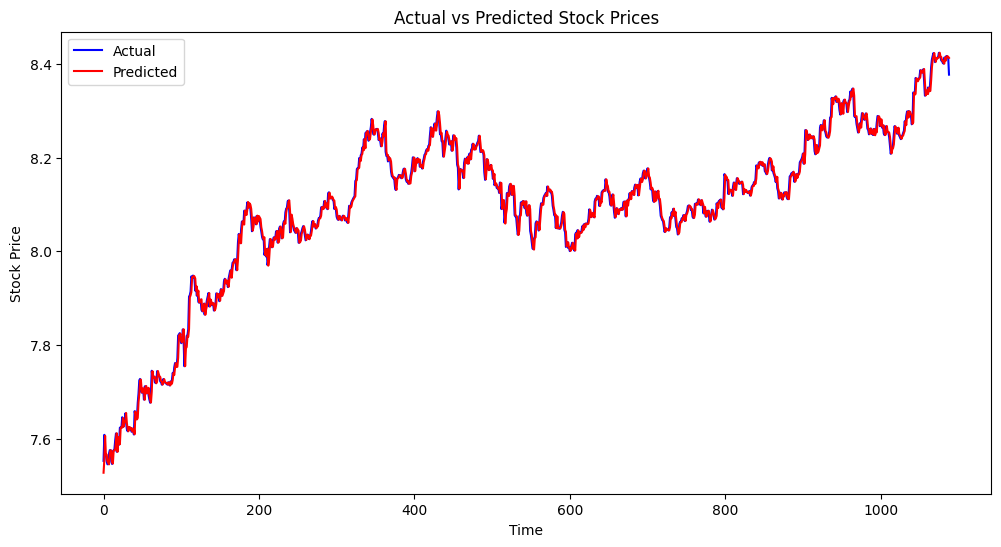

In [59]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Example data setup (ensure y is defined and contains your data)
x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]

history = list(train)  # Use list() to ensure history is a list
predictions = []

# Use exactly 20 test samples
num_predictions = len(test)
cnt = 0

for t in range(len(test)):
    if cnt == num_predictions:
        break
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()  # No disp argument
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.6f}, actual={obs:.6f}')
    cnt += 1

# Ensure predictions and test have the same length
if len(predictions) != num_predictions:
    raise ValueError(f"Predictions length ({len(predictions)}) does not match expected number ({num_predictions})")

# Slice the test set to match the length of predictions
test_slice = test[:num_predictions]

# Calculate error
error = mean_squared_error(test_slice, predictions)
print(f'Test RMSE: {np.sqrt(error):.3f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_slice, label='Actual', color='blue')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [61]:
# Calculate metrics
mae = mean_absolute_error(test_slice, predictions)
mse = mean_squared_error(test_slice, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_slice - predictions) / test_slice)) * 100
r2 = r2_score(test_slice, predictions)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²): {r2:.3f}')

Mean Absolute Error (MAE): 0.010
Mean Squared Error (MSE): 0.000
Root Mean Squared Error (RMSE): 0.014
Mean Absolute Percentage Error (MAPE): 0.13%
R-squared (R²): 0.994


In [97]:
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import matplotlib.pyplot as plt

# x = y.values
# train_size = int(len(x) * 0.7)
# train, test = x[0:train_size], x[train_size:]
# history = [x for x in train]
# predictions = []

# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()  # No disp argument
#     output = model_fit.forecast(steps=1)
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, actual=%f' % (yhat, obs))

# error = mean_squared_error(test, predictions)
# print('Test RMSE: %.3f' % np.sqrt(error))

# plt.plot(test, label='Actual')
# plt.plot(predictions, color='red', label='Predicted')
# plt.legend()
# plt.show()


# 5. Making the predictions 

In [35]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Fit the ARIMA model on the log-transformed data
model = ARIMA(x_log, order=(5,1,0))  # p, d, q
model_fit = model.fit()

# Forecast the next value in the log-transformed scale
forecast_log = model_fit.forecast(steps=1) # next day
forecast_log_value = forecast_log[0]

# Reverse the logarithmic transformation to get the actual price
forecast_value = np.exp(forecast_log_value)

# Get tomorrow's date
today = datetime.now()
tomorrow = today + timedelta(days=1)
tomorrow_date_str = tomorrow.strftime('%Y-%m-%d')  # Format date as YYYY-MM-DD

print(f'The predicted stock price for {tomorrow_date_str} is: {forecast_value:.2f}')


The predicted stock price for 2024-09-20 is: 4348.38


                        Date  Forecasted Price
0 2024-09-20 11:39:09.380203       4348.375978
1 2024-09-21 11:39:09.380203       4351.879816
2 2024-09-22 11:39:09.380203       4353.751390
3 2024-09-23 11:39:09.380203       4355.125962
4 2024-09-24 11:39:09.380203       4350.337551
5 2024-09-25 11:39:09.380203       4350.340210
6 2024-09-26 11:39:09.380203       4350.502635
7 2024-09-27 11:39:09.380203       4350.607259
8 2024-09-28 11:39:09.380203       4350.696217
9 2024-09-29 11:39:09.380203       4350.548856


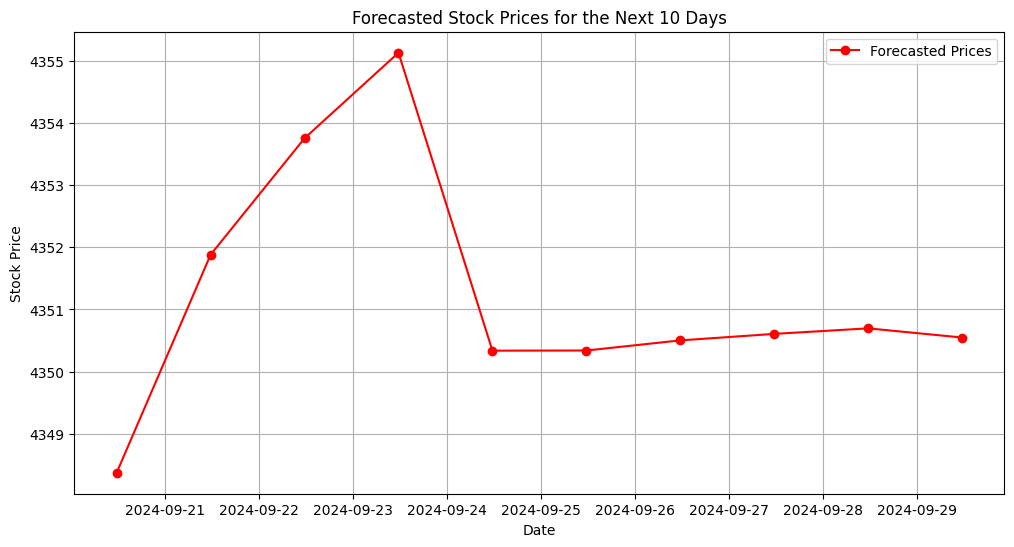

In [36]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Fit the ARIMA model on the log-transformed data
model = ARIMA(x_log, order=(5,1,0))  # p, d, q
model_fit = model.fit()

# Forecast the next 10 days in the log-transformed scale
forecast_log = model_fit.forecast(steps=10)
forecast_log_values = forecast_log

# Reverse the logarithmic transformation to get the actual prices
forecast_values = np.exp(forecast_log_values)

# Generate dates for the next 10 days
last_date = pd.to_datetime('today')  # Adjust if you have a specific end date
dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10, freq='D')

# Create a DataFrame to display results
forecast_df = pd.DataFrame({
    'Date': dates,
    'Forecasted Price': forecast_values
})

print(forecast_df)

# Optional: Plot the forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, forecast_values, marker='o', linestyle='-', color='red', label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted Stock Prices for the Next 10 Days')
plt.legend()
plt.grid()
plt.show()


2. SARIMA

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.532259, actual=7.552578


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.555015, actual=7.608101


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.607267, actual=7.565508


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.566829, actual=7.566699


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.567055, actual=7.551502


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.552243, actual=7.545205


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.546101, actual=7.546129


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.547581, actual=7.568018
predicted=7.567921, actual=7.575328


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.573579, actual=7.575405


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.574965, actual=7.550845


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.551050, actual=7.545865


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.551898, actual=7.573326


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.576775, actual=7.574892


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.573772, actual=7.577429


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.578333, actual=7.596493
predicted=7.594584, actual=7.611026


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.611181, actual=7.571988
predicted=7.570108, actual=7.603549


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=7.605889, actual=7.603050
Test RMSE: 0.022


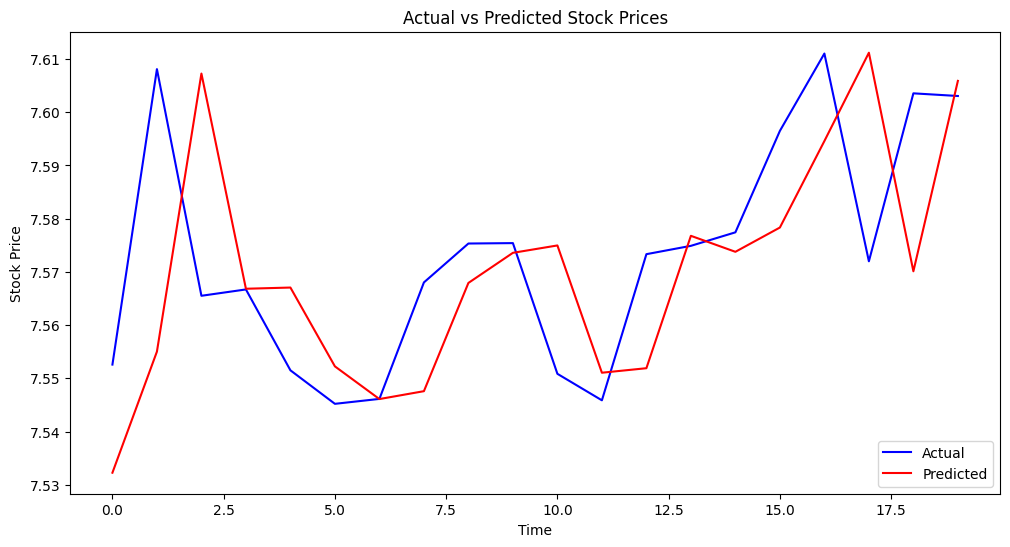

In [37]:
x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]

history = list(train)  # Use list() to ensure history is a list
predictions = []

# Define SARIMA parameters
# Adjust the (p, d, q) and (P, D, Q, s) parameters based on your data
seasonal_period = 12  # Example: monthly data with yearly seasonality
num_predictions = 20
cnt = 0

for t in range(len(test)):
    if cnt == num_predictions:
        break
    model = SARIMAX(history, order=(5,1,0), seasonal_order=(1,1,1,seasonal_period))
    model_fit = model.fit(disp=False)  # No disp argument
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.6f}, actual={obs:.6f}')
    cnt += 1

# Ensure predictions and test have the same length
if len(predictions) != num_predictions:
    raise ValueError(f"Predictions length ({len(predictions)}) does not match expected number ({num_predictions})")

# Slice the test set to match the length of predictions
test_slice = test[:num_predictions]

# Calculate error
error = mean_squared_error(test_slice, predictions)
print(f'Test RMSE: {np.sqrt(error):.3f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_slice, label='Actual', color='blue')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [38]:
# Calculate metrics
mae = mean_absolute_error(test_slice, predictions)
mse = mean_squared_error(test_slice, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_slice - predictions) / test_slice)) * 100
r2 = r2_score(test_slice, predictions)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²): {r2:.3f}')

Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.001
Root Mean Squared Error (RMSE): 0.022
Mean Absolute Percentage Error (MAPE): 0.22%
R-squared (R²): -0.144


In [39]:
model = SARIMAX(x_log, order=(5,1,0), seasonal_order=(1,1,1,12))  # Example parameters
model_fit = model.fit(disp=False)

# Forecast the next value in the log-transformed scale
forecast_log = model_fit.forecast(steps=1) # next day
forecast_log_value = forecast_log[0]

# Reverse the logarithmic transformation to get the actual price
forecast_value = np.exp(forecast_log_value)

# Get tomorrow's date
today = datetime.now()
tomorrow = today + timedelta(days=1)
tomorrow_date_str = tomorrow.strftime('%Y-%m-%d')  # Format date as YYYY-MM-DD

print(f'The predicted stock price for {tomorrow_date_str} is: {forecast_value:.2f}')

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The predicted stock price for 2024-09-20 is: 4356.16


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Date  Forecasted Price
0  2024-09-20       4356.161582
1  2024-09-21       4363.982752
2  2024-09-22       4366.989057
3  2024-09-23       4370.211884
4  2024-09-24       4374.783759
5  2024-09-25       4378.461455
6  2024-09-26       4383.806862
7  2024-09-27       4381.464495
8  2024-09-28       4382.377453
9  2024-09-29       4380.964981


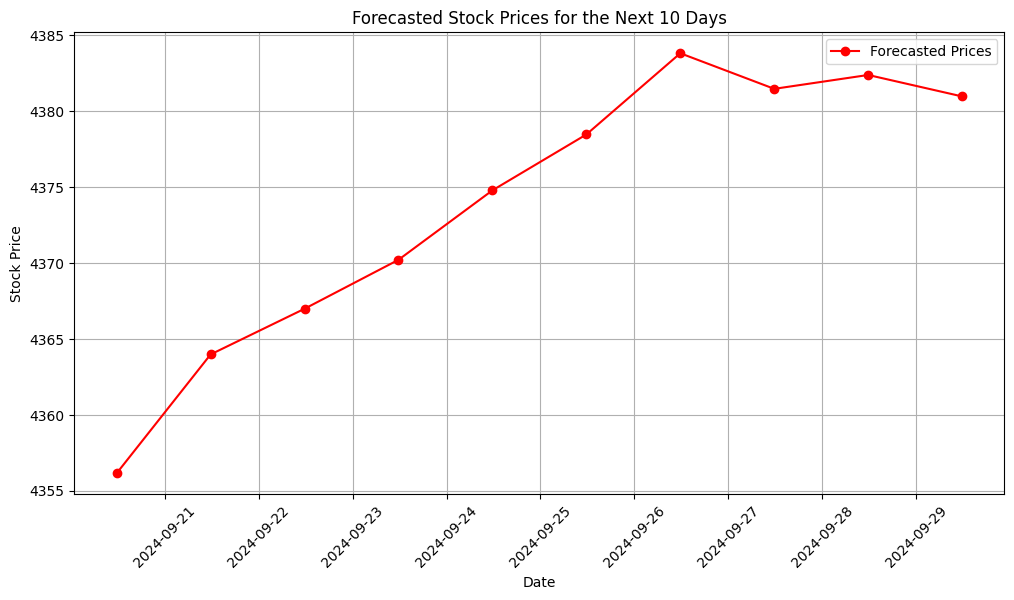

In [40]:
# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Define the SARIMA model
# Example parameters; adjust these based on your data and seasonal period
model = SARIMAX(x_log, order=(5,1,0), seasonal_order=(1,1,1,12))  # Adjust parameters as needed
model_fit = model.fit(disp=False)

# Forecast the next 10 days in the log-transformed scale
forecast_log = model_fit.forecast(steps=10)
forecast_log_values = forecast_log

# Reverse the logarithmic transformation to get the actual prices
forecast_values = np.exp(forecast_log_values)

# Generate dates for the next 10 days
today = datetime.now()
dates = [today + timedelta(days=i+1) for i in range(10)] 
dates_str = [date.strftime('%Y-%m-%d') for date in dates]

# Create a DataFrame to display results
forecast_df = pd.DataFrame({
    'Date': dates_str,
    'Forecasted Price': forecast_values
})

print(forecast_df)

# Optional: Plot the forecasted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, forecast_values, marker='o', linestyle='-', color='red', label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted Stock Prices for the Next 10 Days')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

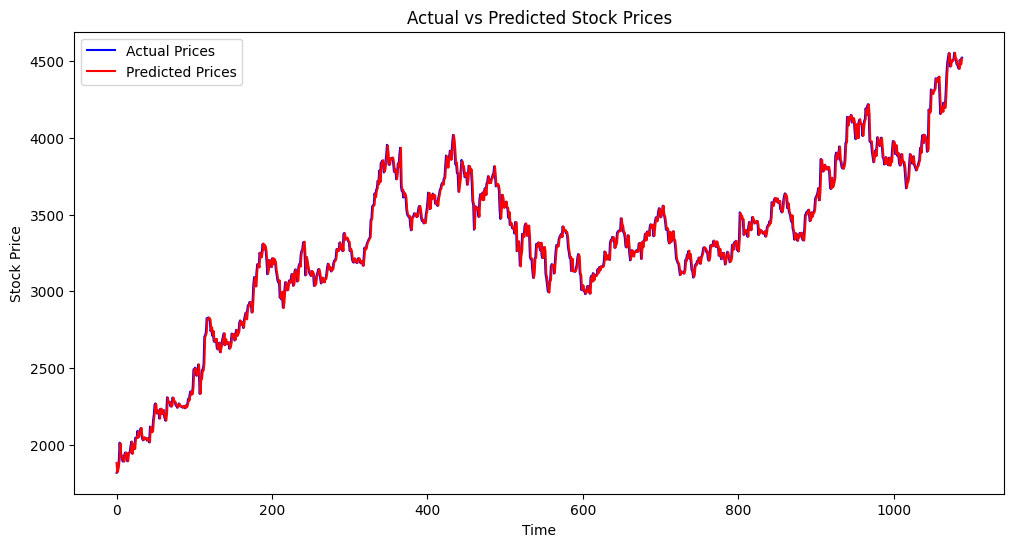

In [44]:
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA

# # Assume y is your log-transformed time series data and already loaded
# x_log = y.values
# train_size = int(len(x_log) * 0.7)
# train, test = x_log[0:train_size], x_log[train_size:]
# test_actual = np.exp(test)  # Convert test data back to original scale
# history = [x for x in train]
# predictions = []

# # Forecasting the test period
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))  # p, d, q
#     model_fit = model.fit()
#     output = model_fit.forecast(steps=1)
#     yhat_log = output[0]
#     yhat = np.exp(yhat_log)  # Convert forecasted log value back to original scale
#     predictions.append(yhat)
#     obs = np.exp(test[t])  # Ensure actual test values are in original scale
#     history.append(test[t])
#     # print('predicted=%f, actual=%f' % (yhat, obs))

# # Convert predictions to a numpy array for easy plotting
# predictions = np.array(predictions)

# # Plot actual vs predicted prices
# plt.figure(figsize=(12, 6))
# plt.plot(test_actual, label='Actual Prices', color='blue')
# plt.plot(predictions, color='red', label='Predicted Prices')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.title('Actual vs Predicted Stock Prices')
# plt.legend()
# plt.show()
